In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import pandas as pd
import keras
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


Using TensorFlow backend.


In [2]:
df=pd.read_csv('quality.csv',sep=";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# ***Data preprocessing ***

In [3]:
df = df[df['quality'] >= 4]
df = df[df['quality'] <= 7]
LE = LabelEncoder()

df['quality'] = LE.fit_transform(df['quality'])



In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1571 non-null   float64
 1   volatile acidity      1571 non-null   float64
 2   citric acid           1571 non-null   float64
 3   residual sugar        1571 non-null   float64
 4   chlorides             1571 non-null   float64
 5   free sulfur dioxide   1571 non-null   float64
 6   total sulfur dioxide  1571 non-null   float64
 7   density               1571 non-null   float64
 8   pH                    1571 non-null   float64
 9   sulphates             1571 non-null   float64
 10  alcohol               1571 non-null   float64
 11  quality               1571 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 159.6 KB


In [5]:
feat=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
X=df[feat]
Y=df['quality']

In [6]:
test_ratio = 0.3
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=test_ratio,random_state=seed)

In [7]:
Y_train = Y_train.reset_index().drop('index',axis=1)
Y_test = Y_test.reset_index().drop('index',axis=1)

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [9]:
print(Y_train.shape)

(1099, 1)


## Training | K-Fold Cross validation

In [18]:
import numpy
es = EarlyStopping(monitor='val_loss',min_delta=1e-5, mode='auto', verbose=0)
# tup=[[0.1,50],[0,1,60],[0.2,50],[0.01,70],[0.3,80],[0.5,60],[0.6,40],[0.6,30],[0.5,40],[0.3,60]]
tup=[[0.1,50],[0.1,60],[0.1,70],[0.01,50],[0.01,60],[0.01,70],[0.01,80],[0.02,80],[0.03,50],[0.001,50],[0.001,60],[0.001,70],[0.001,80]]
tupscore=[]
seed = 7
np.random.seed(seed)
for i in tup:
  n=i[1]
  learning_rate = i[0]
  model = Sequential()
  model.add(Dense(n, input_dim=11, activation='relu'))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
  # kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
  cvscores = []
  kfold = KFold(n_splits=20,random_state=seed,shuffle=True)
  print ("learning rate "+str(i[0])+"  n "+str(n)+" ")
  for train_index, test_index in kfold.split(X_train):
    X_train1 = X_train[train_index]
    X_test1 = X_train[test_index]
    y_train1 = Y_train[train_index]
    y_test1 = Y_train[test_index]
    b = np.zeros((y_train1.size, y_train1.max()+1))
    b[np.arange(y_train1.size),y_train1] = 1
    b1 = np.zeros((y_test1.size, y_test1.max()+1))
    b1[np.arange(y_test1.size),y_test1] = 1
    print(y_train1.shape)
    model.fit(X_train1, b, validation_data=(X_test1, b1), epochs=4000, verbose=0, callbacks=[es])
    scores = model.evaluate(X_test1, b1, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
  print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
  tupscore.append(cvscores)
  

learning rate 0.1  n 50 
(1044,)
accuracy: 54.55%
(1044,)
accuracy: 63.64%
(1044,)
accuracy: 56.36%
(1044,)
accuracy: 63.64%
(1044,)
accuracy: 65.45%
(1044,)
accuracy: 60.00%
(1044,)
accuracy: 54.55%
(1044,)
accuracy: 61.82%
(1044,)
accuracy: 58.18%
(1044,)
accuracy: 54.55%
(1044,)
accuracy: 56.36%
(1044,)
accuracy: 54.55%
(1044,)
accuracy: 56.36%
(1044,)
accuracy: 60.00%
(1044,)
accuracy: 63.64%
(1044,)
accuracy: 52.73%
(1044,)
accuracy: 56.36%
(1044,)
accuracy: 58.18%
(1044,)
accuracy: 72.73%
(1045,)
accuracy: 72.22%
59.79% (+/- 5.54%)
learning rate 0.1  n 60 
(1044,)
accuracy: 58.18%
(1044,)
accuracy: 47.27%
(1044,)
accuracy: 50.91%
(1044,)
accuracy: 69.09%
(1044,)
accuracy: 65.45%
(1044,)
accuracy: 56.36%
(1044,)
accuracy: 54.55%
(1044,)
accuracy: 61.82%
(1044,)
accuracy: 52.73%
(1044,)
accuracy: 52.73%
(1044,)
accuracy: 65.45%
(1044,)
accuracy: 47.27%
(1044,)
accuracy: 50.91%
(1044,)
accuracy: 61.82%
(1044,)
accuracy: 67.27%
(1044,)
accuracy: 56.36%
(1044,)
accuracy: 52.73%
(1044,

# Using Box Plot to Select best set of parameters

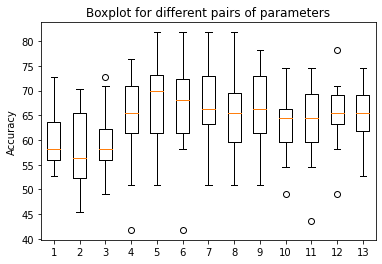

In [19]:
import matplotlib.pyplot as plt
data = []

for score in scores:
    data.append(np.array(tupscore))

fig, ax = plt.subplots()
ax.set_title('Boxplot for different pairs of parameters')
plt.ylabel('Accuracy')
ax.boxplot(tupscore)

plt.show()

As we can see that 13th has close to highest mean accuracy and has some  outliers but has  minimum quartile distance and highest accuracy amongst all.

## Training model on best set of parameters

In [20]:
bestlr=0.03
num_neurons=50
model = Sequential()
model.add(Dense(num_neurons, input_dim=11, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(lr=bestlr),
            metrics=['accuracy'])
feat=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
X=df[feat]
Y=df['quality']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=test_ratio,random_state=seed)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
b = np.zeros((Y_train.size, Y_train.max()+1))
b[np.arange(Y_train.size),Y_train] = 1
b1 = np.zeros((Y_test.size, Y_test.max()+1))
b1[np.arange(Y_test.size),Y_test] = 1
model.fit(X_train, b, validation_data=(X_test, b1), epochs=4000, verbose=0, callbacks=[es])
scores = model.evaluate(X_test, b1, verbose=0)
print('accuracy: ',score)

accuracy:  0.7222222089767456


In [22]:
prediction=model.predict(X_test)
prediction

array([[0.02312945, 0.62287503, 0.34568083, 0.00831473],
       [0.03046857, 0.1380646 , 0.68434155, 0.14712533],
       [0.10716055, 0.24078627, 0.5193306 , 0.1327226 ],
       ...,
       [0.0904512 , 0.38184375, 0.47335404, 0.054351  ],
       [0.01594867, 0.24600677, 0.68491465, 0.05312988],
       [0.02757495, 0.58801144, 0.37764063, 0.00677292]], dtype=float32)

# CMC Curve

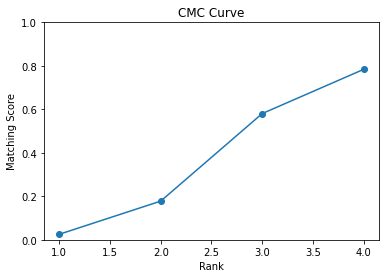

In [24]:
y_preds = []

for i in range(prediction.shape[0]):
    ids = prediction[i].argsort()[::-1]
    y_preds.append(ids)
    
y_preds = np.array(y_preds)

ranks = np.zeros(4)

for i in range(b1.shape[0]) :
    if b1[i] in y_preds[i] :
        firstOccurance = np.argmax(y_preds[i]==b1[i])        
        for j in range(firstOccurance, 4) :            
            ranks[j] +=1
            
cmc_scores = [float(i)/float(b1.shape[0]) for i in ranks]


fig, ax = plt.subplots()

plot_x = np.arange(1,5)

ax.set_title('CMC Curve')
plt.xlabel('Rank')
plt.ylabel('Matching Score')
plt.ylim(0,1)
ax.plot(plot_x,cmc_scores,marker='o')

plt.show()